<p dir="rtl">
<b>0</b></br>

</p>



# import Dependencies

In [1]:
from IPython.display import clear_output

In [2]:
# %pip install torch torch-geometric
clear_output()

In [3]:
import torch
from torch import Tensor
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATConv, SAGEConv, GATv2Conv
import torch.nn as nn
from torch_geometric.data import Data
from torch.optim import Adam

import numpy as np

import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
style.use("ggplot")


import networkx as nx
import matplotlib.pyplot as plt

# define function

## data generator

In [4]:
def make_edge_weight(output : Data,
        num_node=100,
              feature_len=18,
              low = 0, high=10
                ) ->torch.Tensor:

    # weights = np.random.randint( low, high,  (num_node, feature_len))
    weights = np.random.randn( num_node, feature_len)
    # محاسبه هزینه پراکندگی: فاصله بین گره‌ها
    distancess = []
    for i in range(weights.shape[0] ):
        for j in range(i+1, weights.shape[0] ):
            dist = torch.cdist(output.edge_weight[i] ,  output.edge_weight[j])
            distancess.append(dist)
    weights_tensor = torch.tensor(distancess, dtype=torch.float32)

    return weights_tensor

In [5]:
def grid_env(rows: int, cols: int, num_ones : int) -> Tensor:
    # Create a matrix filled with zeros
    matrix: Tensor = torch.zeros((rows, cols), dtype=torch.float32)

    # Get total number of elements in the matrix
    total_elements = rows * cols

    # Ensure that the number of ones does not exceed the total elements
    if num_ones > total_elements:
        pass
        # raise ValueError("Number of ones exceeds the total number of elements in the matrix")

    # Randomly select 'num_ones' positions in the flattened matrix
    ones_indices: Tensor = torch.randperm(total_elements)[:num_ones]

    # Set the selected positions to 1
    matrix.view(-1)[ones_indices] = 1

    return matrix

## edge maker

In [6]:
# creat edge index to connect eveery nodes(liers rows) to each other (fully connected graph)
def make_edge(society : Tensor) -> Tensor:
    num_nodes = society.shape[0]
    edge_index = []
    for i in range(num_nodes):
        for j in range(i + 1, num_nodes):
            edge_index.append([i, j])
            # edge_index.append([j, i])

    edge_index: Tensor = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    return edge_index


## plot Gprah

In [7]:

def plot_matrix_values(matrix: torch.Tensor) -> None:
    # Get the indices where the matrix has values greater than zero (since zero should be ignored in size/color)
    positions = torch.nonzero(matrix >= 0, as_tuple=False)

    # Extract the x and y coordinates and the values at those positions
    x_coords: Tensor = positions[:, 1]  # Column indices (horizontal axis)
    y_coords = positions[:, 0]  # Row indices (vertical axis)
    values = matrix[y_coords, x_coords]  # The values at these positions

    # Scale marker size based on values; for better visibility, multiply values by a scale factor
    marker_size = values * 200  # Scale factor (adjust as needed)

    # Normalize values to range [0, 1] for color fading
    normalized_values = (values - values.min()) / (values.max() - values.min())

    # Create a scatter plot using seaborn, with size and color based on the values
    plt.figure(figsize=(matrix.size(0) , matrix.size(1) ))
    scatter = sns.scatterplot(x=x_coords, y=y_coords,
                              size=values, sizes=(10_000, 0),  # Size based on values
                              hue=normalized_values, c="b", marker='o', legend=False,
                              alpha=0.3 + 0.7 * normalized_values)  # Color fading for low values
    scatter = sns.scatterplot(x=x_coords, y=y_coords,
                              size=values, sizes=(100, 0),  # Size based on values
                               c="k", marker='o', legend=False,
                              # alpha=0.3
                              )
    # Set axis limits and labels
    plt.xlim(-0.5, matrix.size(1) - 0.5)
    plt.ylim(-0.5, matrix.size(0) - 0.5)
    plt.gca().invert_yaxis()  # Invert y-axis to match matrix layout
    # plt.xlabel('X Position')
    # plt.ylabel('Y Position')
    # plt.axis("off")
    # plt.title('Area Coverage')
    # Add a colorbar to show the value mapping
    # plt.colorbar(scatter.collections[0], label='Value')
    plt.grid(True)
    plt.show()


In [8]:
def create_graph_from_matrix(matrix, threashold = 1, *args, **kwargs) -> nx.Graph:
    # Create an empty graph
    G = nx.Graph()

    # Get the positions of ones in the matrix
    device_positions = torch.nonzero(matrix >= threashold, as_tuple=False)
    num = device_positions[device_positions==1].sum()
    weights = kwargs.get("weights",None)
    # Add each position as a node in the graph
    for i, pos in enumerate(device_positions):
        G.add_node(i, pos=(pos[1].item(), pos[0].item()))  # Using (x, y) coordinates

    # Add edges between all pairs of nodes (fully connected graph)
    for i in range(len(device_positions)):
        for j in range(i + 1, len(device_positions)):
            G.add_edge(i, j,weight= round(weights[i].item() , 2) if not weights==None else 0)

    return G

def plot_graph(G : nx.Graph):
    # Get positions of nodes for plotting
    pos = nx.get_node_attributes(G, 'pos')
    G.add_weighted_edges_from(nx.get_edge_attributes(G, "pos") )
    # Draw the graph
    plt.figure(figsize=(6, 6))
    nx.draw(G, pos, with_labels=True, node_color='cyan', node_size=500, edge_color='gray')
    edge_labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

    # plt.title("Fully Connected Graph of Device Positions")
    plt.show()

In [9]:
def rearrange_sensors(output, num_sensors):
    flat_output = output.view(-1)
    _, indices = torch.topk(flat_output, num_sensors)
    new_grid = torch.zeros_like(flat_output)
    new_grid[indices] = 1
    return new_grid.view_as(output)

# define Model and loss function

In [10]:
# class GCN_Model(torch.nn.Module):
#     def __init__(self, num_node_features, hidden_channels: tuple[int], output_channels, num_edges):
#         super(GCN_Model, self).__init__()
#         # GCN layers
#         self.conv1 = GCNConv(num_node_features, hidden_channels[0])
#         self.convs = [GCNConv(hidden_channels[lyr], hidden_channels[lyr+1])
#                       for lyr in range(len(hidden_channels) - 1)]
#         self.last = GCNConv(hidden_channels[-1], output_channels)

#         # Initialize trainable edge weights
#         self.edge_weight = torch.nn.Parameter(torch.rand(num_edges), requires_grad=True)

#     def forward(self, data : Data):
#         x, edge_index, _ = data.x, data.edge_index, data.edge_weight
#         num_sensor =  int(x[x == 1].sum())
#         # Use the trainable edge weights
#         x = self.conv1(x, edge_index, self.edge_weight)
#         x = F.relu(x)
#         for conv in self.convs:
#             x = conv(x, edge_index, self.edge_weight)
#             x = F.relu(x)
#         x = self.last(x, edge_index, self.edge_weight)

#         # x = F.softmax(x, dim=-1)
#         # x = F.sigmoid(x)
#         return Data(x=x, edge_index=edge_index, edge_weight=self.edge_weight.abs())

from torch_geometric.nn import GATConv

class GAT(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=2):
        super(GAT, self).__init__()
        self.gat1 = GATConv(in_channels, hidden_channels, heads=heads)
        self.gat2 = GATConv(hidden_channels * heads, out_channels, heads=1)

    def forward(self, data):
        x , edge_index = data.x , data.edge_index
        x = F.elu(self.gat1(x, edge_index))
        x = self.gat2(x, edge_index)
        return Data(x=x, edge_index=edge_index)


In [11]:
class EvolvingCoverageLoss(nn.Module):
    def __init__(self, alpha=0.5, R=1.0, D=0.5):
        super(EvolvingCoverageLoss, self).__init__()
        self.alpha = torch.tensor(alpha)
        self.R = R
        self.D = D

    def forward(self, output, target):
        # Calculate pairwise distances
        # distances = torch.cdist(output, target)
        output.x.requires_grad_()
        # Mask for coverage (distances > R) and connectivity (distances > D)
        coverage_mask = F.softmax(output.x - self.R, dim=0)
        connectivity_mask = F.softmax(output.x - self.D, dim=0)

        # Compute coverage and connectivity loss using masks
        coverage_loss = coverage_mask.float().mean()
        connectivity_loss = connectivity_mask.float().mean()

        # Total loss (weighted sum of coverage and connectivity losses)
        total_loss:torch.Tensor = (self.alpha * coverage_loss) + ((1 - self.alpha) * connectivity_loss)

        return  total_loss, coverage_loss, connectivity_loss


# Train Function

In [ ]:
def train(data,
          model,
          optimizer,
          loss_function,
          num_epoch = 10,
          verbose=False):


    losses ,covs , distro = [],[], []
    model.train()  # Set the model to training mode

    for epoch in range(num_epoch):
        optimizer.zero_grad()  # Reset gradients

        # Forward pass
        output = model(data)

        # Compute loss
        loss = F.mse_loss(output.x, data.x)
        loss, coverage_cost, distribution_cost = loss_function(data, output)
        # covs.append(coverage_cost.item())
        # distro.append(distribution_cost.item())
        losses.append(loss.item())
        # Backward pass (backpropagation)
        loss.backward()

        # Optimizer step (update model weights)
        optimizer.step()

        # Print loss every 10 epochs
        if epoch % 10 == 0 and verbose:
            print(f"Epoch {epoch}/{num_epoch} | Loss: {loss.item(): .2f}")
    return losses, covs, distro

: 

# Test training

In [ ]:
Num_sensors = 6
grid_x, grid_y = 10,10



env = grid_env(grid_x, grid_y ,Num_sensors)
# plot_device_positions(env)
G = create_graph_from_matrix(env)
# plot_graph(G)
edges_index = torch.tensor(list(G.edges()), dtype=torch.long).t().contiguous()



# num_data, num_feature = sensor_weights.shape


# Change: Random initialization of edge weights
num_edges = edges_index.size(1)
edge_weight = torch.randn(num_edges)  # Random values for edge weights

graph_data: Data = Data(x=env, edge_index=edges_index , edge_weight = edge_weight ,shuffle=False)

# Model = GCN_Model(
#                 num_node_features=10,
#                 hidden_channels=(10,),
#                 output_channels=10,
#                 num_edges=num_edges)

Model = GAT(
                in_channels=10,
                hidden_channels=10,
                out_channels=10,
                heads=2
                )

loss_fn = EvolvingCoverageLoss(
                                alpha=.5 ,
                                R = .5,
                                D= .5 ,
                                )
# تنظیمات بهینه‌ساز
optimizer = Adam([
    {'params': Model.parameters()},  # بهینه‌سازی پارامترهای مدل
    # {'params': loss_fn.target_points},  # بهینه‌سازی نقاط هدف
    # {'params': loss_fn.alpha},
    # {'params': EvolvingCoverageLoss().beta}

    ], lr=0.1)


# train
losses, covs, distro = train(data=graph_data,
                    model=Model,
                    optimizer=optimizer,
                    loss_function = loss_fn,
                    num_epoch=100 ,
                    verbose=True)

output:Data = Model(graph_data)
# print("before \n", graph_data.x)
print("\n\n""Node embeddings after GCN layers:\n", output.x)

Epoch 0/100 | Loss:  0.10
Epoch 10/100 | Loss:  0.10
Epoch 20/100 | Loss:  0.10
Epoch 30/100 | Loss:  0.10
Epoch 40/100 | Loss:  0.10
Epoch 50/100 | Loss:  0.10
Epoch 60/100 | Loss:  0.10
Epoch 70/100 | Loss:  0.10
Epoch 80/100 | Loss:  0.10


In [ ]:
# env

In [ ]:
output_: Tensor = rearrange_sensors(output.x,5)

In [ ]:
def plot_matrix_values(matrix: torch.Tensor):
    # Get the indices where the matrix has values greater than zero (since zero should be ignored in size/color)
    positions = torch.nonzero(matrix > 0, as_tuple=False)

    # Extract the x and y coordinates and the values at those positions
    x_coords = positions[:, 1]  # Column indices (horizontal axis)
    y_coords = positions[:, 0]  # Row indices (vertical axis)
    values = matrix[y_coords, x_coords]  # The values at these positions

    # Scale marker size based on values; for better visibility, multiply values by a scale factor
    marker_size = values * 200  # Scale factor (adjust as needed)

    # Normalize values to range [0, 1] for color fading
    normalized_values = (values - values.min()) / (values.max() - values.min())

    # Create a scatter plot using seaborn, with size and color based on the values
    plt.figure(figsize=(matrix.size(0)//2 , matrix.size(1)//2 ))
    scatter = sns.scatterplot(x=x_coords, y=y_coords,
                              size=values, sizes=(50_000, 10_000),  # Size based on values
                              hue=normalized_values, c="b", marker='o', legend=False,
                              alpha=0.3 + 0.7 * normalized_values)  # Color fading for low values
    scatter = sns.scatterplot(x=x_coords, y=y_coords,
                              size=values, sizes=(100, 0),  # Size based on values
                               c="k", marker='o', legend=False,
                              # alpha=0.3
                              )
    # Set axis limits and labels
    plt.xlim(-0.5, matrix.size(1) - 0.5)
    plt.ylim(-0.5, matrix.size(0) - 0.5)
    plt.gca().invert_yaxis()  # Invert y-axis to match matrix layout
    # plt.xlabel('X Position')
    # plt.ylabel('Y Position')
    # plt.axis("off")
    # plt.title('Area Coverage')
    # Add a colorbar to show the value mapping
    # plt.colorbar(scatter.collections[0], label='Value')
    plt.grid(True)
    plt.show()


In [ ]:
output_

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 1., 0., 0., 1., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

: 

In [ ]:
plot_matrix_values(output_. detach())

[]

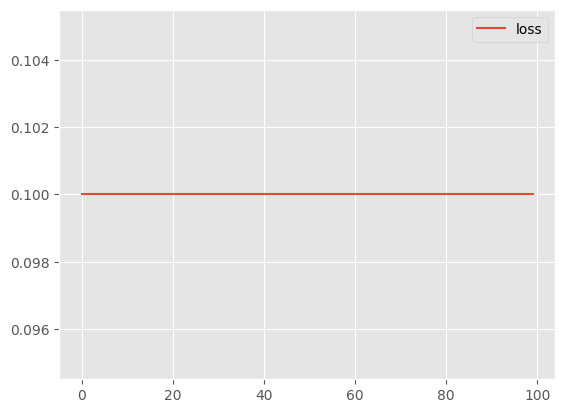

In [ ]:
sns.lineplot({"loss" : losses,
            # "coverage cost":covs,
            # "distribution cost" : distro
            })

plt.plot()

In [ ]:
T = create_graph_from_matrix(output_, 1,
                            )

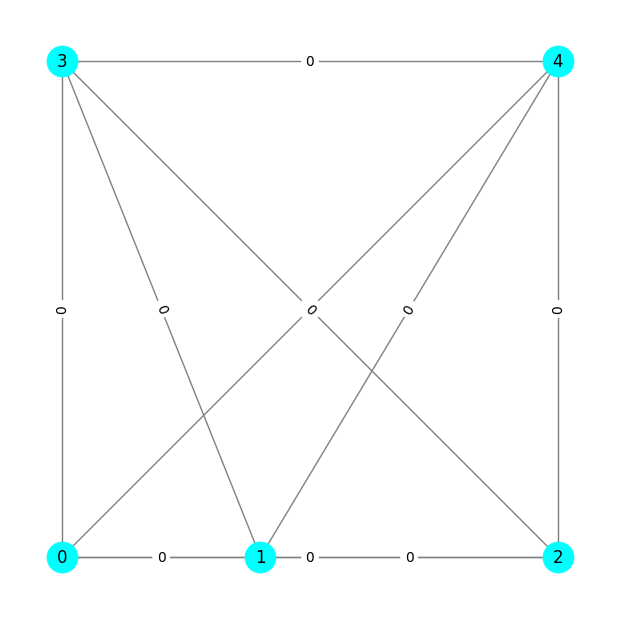

In [ ]:
plot_graph(T)

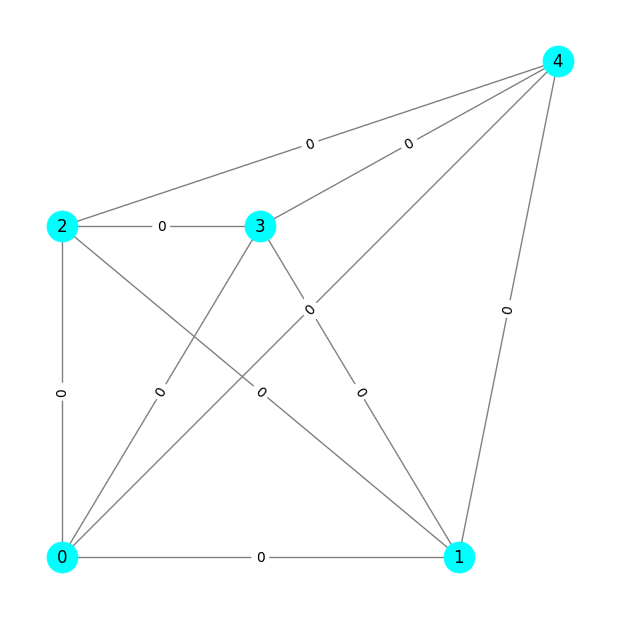

In [ ]:
plot_graph(G)

